# Note: in markdown cells, It's probably easiest to leave any notes we intend to remove before submission with red text or something along those lines. That way, we can easily find them later and remove them before submitting. 

Red text can be added in markdown cells with the following syntax: \<font color='red'\>text\</font\> (replace 'text' with the text you want to be red). It'll look like this: <font color='red'>text</font>


### AST 5731 
#### Group 3 - Project 2
#### Group Members: Thomas Atkins, Tyler Barna, Tore Boybei, and Haowen Zhong

#### Contents

<font color='red'> the hyperlinks won't work when viewing the notebook on github, but they should work when viewing the notebook on jupyter notebook or when exported as an html file </font>

<font color='red'>some of these sections may not be necessary/some more may be needed</font>

 1. [Introduction](#introduction)
 2. [Data](#data)  
    2.1 [Importing Data](#importing-data)    
    2.2 [Data Visualization](#visualization)
 3. [Analysis](#analysis)   
    3.1 [Components of Statistical Model](#model)  
    3.2 [Prior Predictive Check](#prior)     
    3.3 [Posterior](#posterior)     
    3.4 [Sensitivity Analysis](#senstivity)  
    3.5 [Posterior Predictive Check](#ppc)   
 4. [Results](#results)

### 1. Introduction 
<a id='introduction'></a>

Galaxies represent the intersection of a multitude of complex systems, all interrelated to varying degrees. By studying the statistical relationships between various properties of galaxies, we can gain insight into the way galaxies form.

### 2. Data
<a id='data'></a>

While we follow Harris et al. 2014, the actual data used for our analysis is from an earlier paper, [Harris et al. 2013](https://iopscience.iop.org/article/10.1088/0004-637X/772/2/82/meta), which is a catalog of globular cluster systems compiled from 101 literatue sources. The full dataset and accompanying sources can be found on the personal website of the first author, located [here](https://physics.mcmaster.ca/~harris/GCS_table.txt).

Note: Our project was run on python 3.9.13, and an environment package detailing the versions for all packages used can be found [here](https://github.com/tylerbarna/AST5731-projects/blob/main/environment.yml).

Importing packages used for project: 

In [1]:
import csv
import dis
import inspect
import os
import sys
import time

import astropy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as mc
import random
import scipy as sp
import scipy.stats as stats
import seaborn as sns
import time
import warnings
import arviz as az
warnings.filterwarnings('ignore')

from astropy import units as u
from astropy import constants as const
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.io import ascii
from astropy.time import Time
from astropy.time import TimeDelta
from astropy.timeseries import TimeSeries
from astropy.visualization import time_support
time_support()
from astropy.visualization import quantity_support
quantity_support()

from IPython.display import display_html
from IPython.display import Image

from numpy import interp

from scipy import integrate
from scipy import linalg as la
from scipy import optimize

from scipy.stats import beta
from scipy.stats import betabinom
from scipy.stats import binom
from scipy.stats import gamma
from scipy.stats import invgamma
from scipy.stats import multivariate_normal as mvn
from scipy.stats import nbinom
from scipy.stats import norm
from scipy.stats import poisson
from scipy.stats import t
from scipy.stats import uniform

from sklearn import preprocessing as pp

%matplotlib inline
plt.style.use("seaborn-colorblind")
mpl.rcParams.update({"axes.grid" : False})
plt.style.context(("seaborn-colorblind",))
plt.rc("text", usetex=True)
plt.rc("font", family="serif")
## set seed for reproducibility
random.seed(5731)

#### 2.1 Importing Data
<a id='importing'></a>  

The data was acquired as a .txt file, with each row representing a galaxy and each column representing a property of that galaxy. The properties are as follows:

1. Galaxy ID
2. Galaxy Morphology
3. Number of Globular Clusters in Galaxy ($N_{GC}$)
4. Number of Globular Clusters Uncertainty
5. Dynamical Mass of Galaxy Bulge ($M_{Dyn}$)*, in units of $\text{log} \left(\frac{M_{Dyn}}{M_{\odot}}\right)$ 
6. Mass of Central Black Hole ($M_{BH}$), in units of $\text{log} \left(\frac{M_{BH}}{M_{\odot}}\right)$
7. Velocity Dispersion ($\sigma_e$), in units of $\frac{km}{s}$
8. Velocity Dispersion Uncertainty
9. Foreground Absorption/Extinction ($A_V$)
10. Absolute Visual Magnitude ($M_V^T$)
11. Absolute Visual Magnitude Uncertainty
12. Absolute Magnitude in K-band ($M_K$) (Near-IR) 
13. Effective Radius ($R_e$), in units of Kiloparsecs
14. Black Hole Mass Upper Uncertainty
15. Black Hole Mass Lower Uncertainty

*Note: $M_{Dyn}$ is a derived quantity, given by the equation

$$
\begin{equation}
M_{Dyn} = \frac{4 \sigma_e^2 R_e}{G}
\end{equation}
$$

where $\sigma_e$ and $R_e$ are two of the observables listed above and $G$ is the universal gravitational constant.

In [2]:
df_ = pd.read_csv('dat.txt',index_col=0,
                 dtype={'Galaxy':str, 'Type':str,
                        'N_GC':np.float64, 'N_GC_err':np.float64,
                        'Mdyn':np.float64, 'MBH':np.float64,
                        'sig_e':np.float64, 'err_sig_e':np.float64,
                        'A_V':np.float64, 'MV_T':np.float64,
                        'err_MV_T':np.float64, 'MK':np.float64,
                        'Re':np.float64, 'upMBH':np.float64,
                        'lowMBH':np.float64
                        })
df_.rename({'err_sig_e':'sig_e_err', 'err_MV_T':'MV_T_err'}, axis=1, inplace=True) ## for consistency
display(df_.head())
display(df_.describe())

for type in df_['Type'].unique():
    print('Number of {} Galaxies: {}'.format(type,len(df_[df_['Type']==type])))

,Galaxy,Type,N_GC,N_GC_err,Mdyn,MBH,sig_e,sig_e_err,A_V,MV_T,MV_T_err,MK,Re,upMBH,lowMBH
1,MilkyWay,S,160.0,10.0,9.856,6.61,105.0,20.0,0.000,-21.30,0.30,NaN,0.70,0.04,0.04
2,WLM,Irr,1.0,0.0,NaN,NaN,NaN,NaN,0.088,-14.84,0.20,NaN,NaN,NaN,NaN
3,NGC7814,S,150.0,40.0,10.879,NaN,169.2,7.2,0.147,-20.18,0.28,-23.531,2.84,NaN,NaN
4,NGC55,S,36.0,15.0,NaN,NaN,NaN,NaN,0.036,-18.77,0.20,-20.356,2.31,NaN,NaN
5,NGC147,E,10.0,2.0,8.408,NaN,22.0,5.0,0.475,-15.46,0.30,-17.254,0.57,NaN,NaN


,N_GC,N_GC_err,Mdyn,MBH,sig_e,sig_e_err,A_V,MV_T,MV_T_err,MK,Re,upMBH,lowMBH
count,421.000000,422.000000,256.000000,65.000000,274.000000,274.000000,422.000000,421.000000,421.000000,351.000000,343.000000,65.000000,65.000000
mean,1573.788599,396.078199,10.715344,5.944154,167.854745,7.355839,0.130540,-19.130926,0.236841,17071.801422,4.260933,2.394154,0.117231
std,4181.748799,1435.582276,0.972814,3.923606,93.381261,5.604451,0.202398,2.792806,0.108609,129809.646248,6.072945,3.664595,0.130845
min,0.000000,0.000000,7.693000,0.000000,10.400000,0.700000,0.000000,-24.190000,0.200000,-27.080000,0.130000,0.030000,0.000000
25%,15.000000,6.000000,9.988500,0.000000,85.150000,3.700000,0.052000,-21.310000,0.200000,-24.664000,1.265000,0.090000,0.000000
50%,72.000000,17.000000,10.867500,7.950000,168.100000,5.800000,0.081500,-19.590000,0.200000,-23.126000,2.220000,0.160000,0.090000
75%,660.000000,187.750000,11.406000,8.720000,239.200000,9.675000,0.138500,-16.910000,0.210000,-20.412500,4.540000,6.320000,0.160000
max,32500.000000,20000.000000,12.726000,10.320000,414.000000,46.500000,2.583000,-11.170000,1.440000,999999.000000,55.000000,9.950000,0.620000


Number of S Galaxies: 55
Number of Irr Galaxies: 26
Number of E Galaxies: 247
Number of S0 Galaxies: 94


We filter the data to exclude any objects without data on the properties we will analyze. We do this so the relationship between different properties is not affected by objects with missing data.

This filters out all irregular galaxies and reduces the number of galaxies being analyzed from roughly 420 to 64, or a reduction of about 85% overall. For spiral (S) galaxies, approximately 85% of the candidates are discarded. For elliptical (E) galaxies, around 83% of candidates are discarded. Similarly, lenticular (S0) galaxies have about 83% of their candidates discarded. Excluding irregular galaxies, the proportion of removed candidates between different galaxy types is fairly similar.

In [3]:
df = df_.copy()
for var in ['N_GC', 'Mdyn', 'MBH', 'sig_e', 'A_V', 'MV_T', 'Re']:
    df = df[np.isfinite(df[var])]

In [4]:
df = df_.copy()
for var in ['N_GC', 'Mdyn', 'MBH', 'sig_e', 'A_V', 'MV_T', 'Re']:
    df = df[np.isfinite(df[var])]
    
display(df.head())
display(df.describe())

for type in df['Type'].unique():
    print('Number of {} Galaxies: {}'.format(type,len(df[df['Type']==type])))

,Galaxy,Type,N_GC,N_GC_err,Mdyn,MBH,sig_e,sig_e_err,A_V,MV_T,MV_T_err,MK,Re,upMBH,lowMBH
1,MilkyWay,S,160.0,10.0,9.856,6.61,105.0,20.0,0.000,-21.30,0.30,NaN,0.70,0.04,0.04
7,NGC205,E,11.0,3.0,8.775,0.00,31.2,4.7,0.170,-16.66,0.20,-18.947,0.66,4.58,0.00
8,NGC221,E,0.0,1.0,8.843,6.46,75.0,3.0,0.170,-16.54,0.21,-19.327,0.13,0.08,0.10
9,NGC224,S,450.0,100.0,11.046,8.18,160.0,8.0,0.170,-21.80,0.20,-23.467,4.66,0.20,0.10
11,NGC253,S,90.0,40.0,10.571,7.00,102.6,18.8,0.051,-21.01,0.20,-23.979,3.80,0.30,0.30


,N_GC,N_GC_err,Mdyn,MBH,sig_e,sig_e_err,A_V,MV_T,MV_T_err,MK,Re,upMBH,lowMBH
count,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,63.000000,64.000000,64.000000,64.000000
mean,2190.375000,441.765625,11.098203,5.901250,214.318750,8.767188,0.124969,-21.238281,0.230000,-24.157333,5.192813,2.429688,0.116562
std,3590.416749,775.597010,0.766121,3.939225,87.919507,4.844996,0.074094,1.459538,0.067917,1.540675,4.227364,3.682261,0.131767
min,0.000000,1.000000,8.775000,0.000000,31.200000,2.900000,0.000000,-23.470000,0.200000,-26.521000,0.130000,0.030000,0.000000
25%,212.250000,44.250000,10.769250,0.000000,159.175000,4.700000,0.073250,-22.255000,0.200000,-25.145000,2.057500,0.087500,0.000000
50%,520.000000,150.000000,11.116000,7.935000,211.000000,8.000000,0.105500,-21.305000,0.200000,-24.125000,3.720000,0.160000,0.085000
75%,2298.250000,500.000000,11.651500,8.725000,257.200000,11.150000,0.169250,-20.792500,0.220000,-23.745000,7.330000,6.335000,0.165000
max,18000.000000,4500.000000,12.354000,10.320000,414.000000,20.000000,0.381000,-16.540000,0.530000,-18.947000,17.380000,9.950000,0.620000


Number of S Galaxies: 8
Number of E Galaxies: 40
Number of S0 Galaxies: 16


#### 2.3 Data Visualization
<a id='visualization'></a>

Harris et al. 2014 suggests that there are several observable quantities that scale fairly linearly with the number of globular clusters in a galaxy.

We plot the number of globular clusters in a galaxy against several observables in our dataset to see if this is the case.

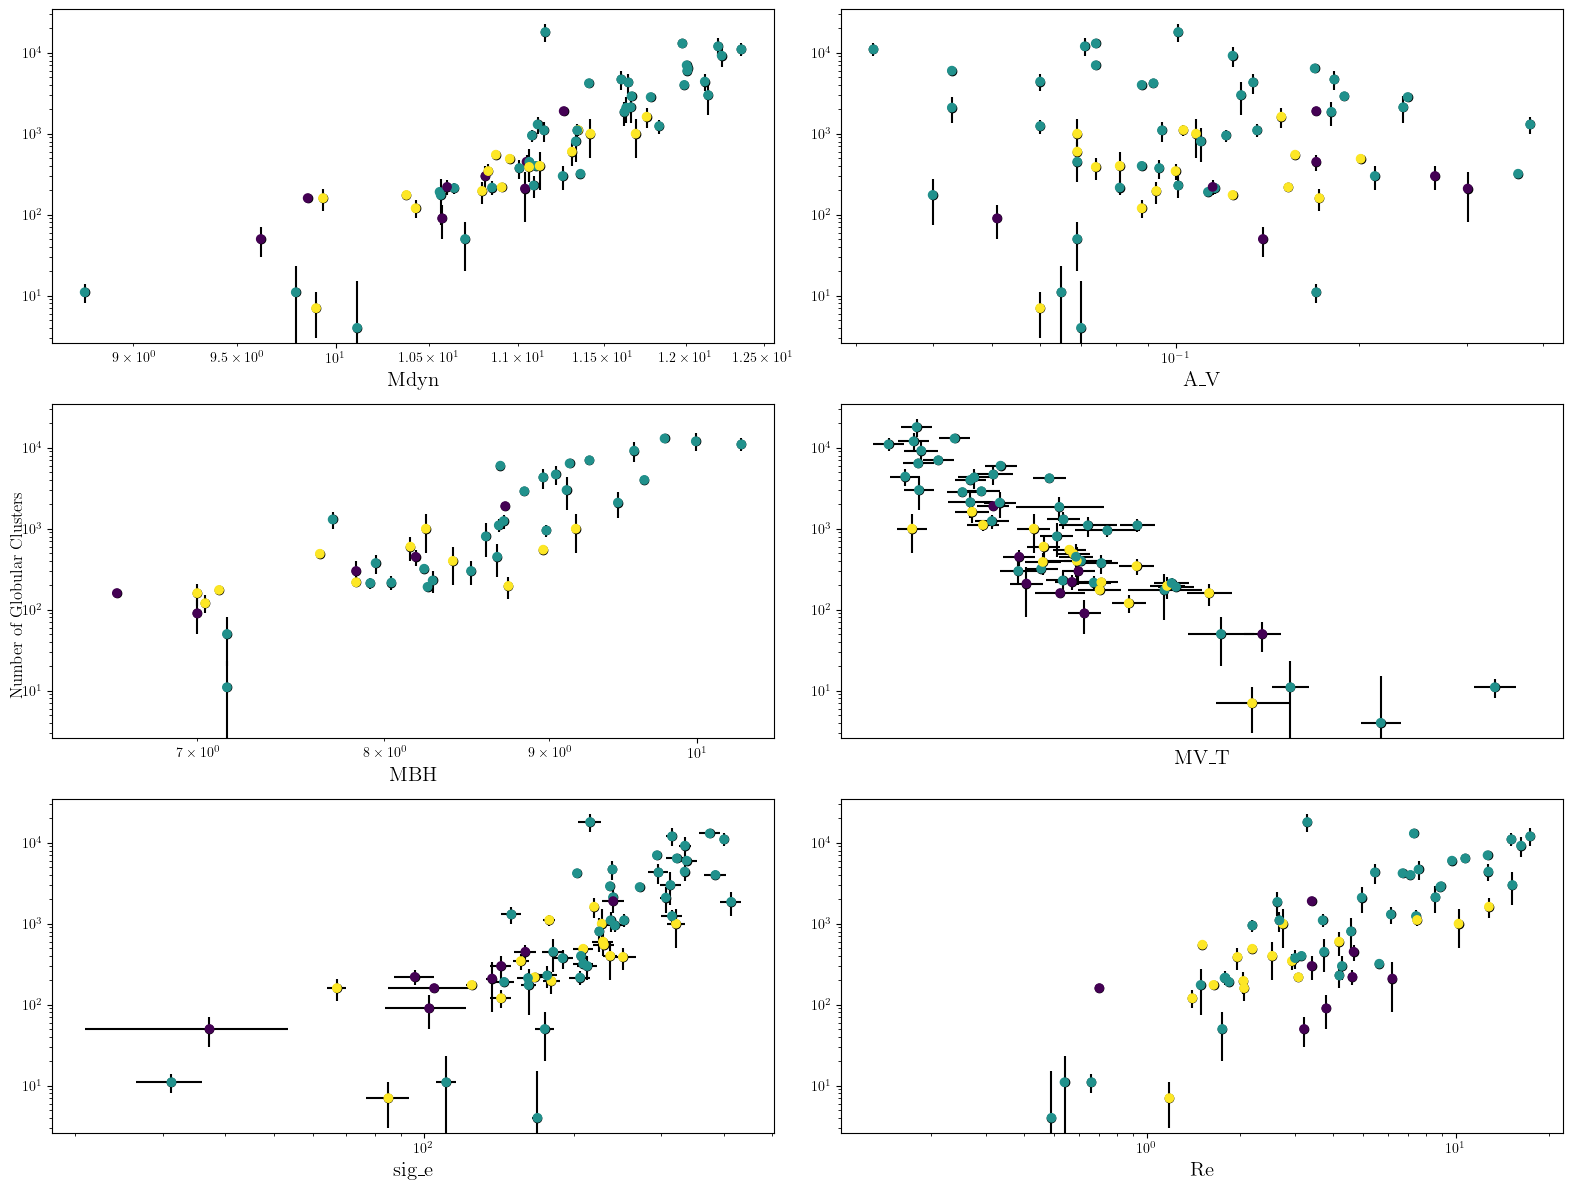

In [5]:
## scatterplot of different variables
def scatterplot(df, var, ax):
    try:
        ax.errorbar(df[var], df['N_GC'], xerr=df[var+'_err'], yerr=df['N_GC_err'], fmt='o', c='black')
    except:
        ax.errorbar(df[var], df['N_GC'], yerr=df['N_GC_err'], fmt='o', c='black')
    ax.scatter(df[var], df['N_GC'], c=df['Type'].factorize()[0], zorder=100)
    avgVar = df[var].mean()
    if avgVar < 0:
        ax.set_xscale('symlog')
    else:
        ax.set_xscale('log')
    ax.set_xlabel(var, fontsize=15)
    ax.set_yscale('log')

fig, axs = plt.subplots(3, 2, figsize=(16,12))
fig.set_tight_layout(True)
vars = ['Mdyn', 'MBH', 'sig_e', 'A_V', 'MV_T', 'Re']
for i, var in enumerate(vars):
    scatterplot(df, var, axs[i%3][i//3])
    axs[i%3][i//3].set_xlabel(var)
fig.supylabel('Number of Globular Clusters')
plt.show()

From visual inspection alone, the only observable that doesn't seem to have at least somewhat plausible linear scaling with the number of globular clusters is the foreground extinction. From an astronomical perspective, this makes sense: some of the absorption occurs due to dust between the galaxy and the observer, and the amount of dust between the galaxy and the observer is not directly related to the number of globular clusters in the galaxy. The absorption coefficent could potentially have a relationship with the distance to a galaxy since there would theoretically be more dust between the galaxy and the observer the farther away the galaxy is. There could also be a relationship between the number of globular clusters in a galaxy and the distance/age of a galaxy, which could  link between absorption coefficient and number of globular clusters. However, this is a fairly tenuous connection, and this is not a relationship we could necessarily test with the data we have and the model we use. 

For the other observable quantities, there seems to be varying degrees of linear scaling with the number of globular clusters. The dynamical mass, absolute visual magnitude, and effective radius have fairly clear linear scaling, whereas both the black hole mass and velocity dispersion have a more ambiguous relationship. The latter two quantities have a handful of outlier galaxies at the lower end that make the relationship less clear.

<Figure size 2000x1000 with 0 Axes>

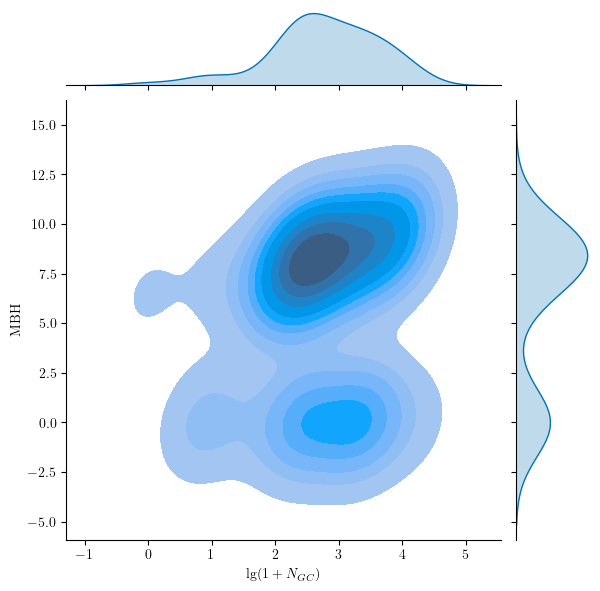

<Figure size 2000x1000 with 0 Axes>

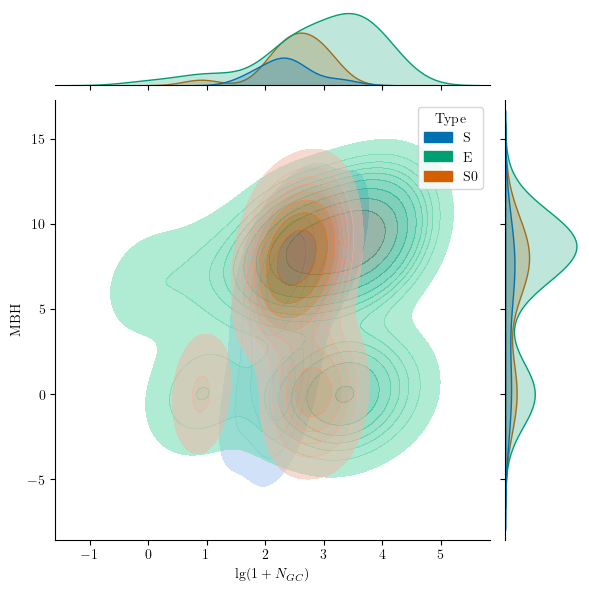

In [6]:
## joint plot of number of globular clusters and mass of black hole
log_gc = np.log10(1+df['N_GC'])
plt.figure(figsize=(20, 10), facecolor='w', edgecolor='k');
plot = sns.jointplot(data=df, x=log_gc,y='MBH',
              kind='kde', fill=True);
plot.ax_joint.set_xlabel(r"$\lg(1+N_{GC})$")
plt.show();

## joint plot of number of globular clusters and mass of black hole by type
plt.figure(figsize=(20, 10), facecolor='w', edgecolor='k');
plot = sns.jointplot(data=df, x=log_gc,y='MBH', hue='Type',
              kind='kde', fill=True, alpha=0.5);
plot.ax_joint.set_xlabel(r"$\lg(1+N_{GC})$");
plt.show();

Visual inspection of the globular cluster joint plot, specically the histogram, suggests that the number of globular clusters in a galaxy may follow a poisson distribution. The histogram of the central black hole mass demonstrates two peaks: One at roughly 7.5 and a smaller peak at around 0. Recall that the black hole "mass" is actually the log of the black hole mass in units of solar masses. A black hole mass around or below 0 likely corresponds to a galaxy without a central black hole. Common astronomical literature suggests that more galaxies have central black holes than not, particularly larger galaxies, which agrees with the distribution we see in our data.

For the joint plot that colors the contour by the galaxy morphology, we see that the black hole mass distribution follows roughly the same distribution irrespective of morphology. However, elliptical galaxies seem to generally have a higher number of globular clusters, though they also have a much more spread out distribution compared to other morphologies. Spiral galaxies seem to have the least spread out contour, with lenticular galaxies in between.

### 3. Bayesian Analysis
<a id='analysis'></a>

#### 3.1 Components of Statistical Model
<a id='model'></a>

Our Poisson regression model is as follows. We incorporate measurement error in x.

$$
Y \sim Poisson(e^{X^*\beta})\\
X^*\sim \mathcal{N}(X, X_{err}^2)\\
\beta \sim \mathcal{N}_9(0, 10^3I_9).
$$

We place a wide prior on $\beta$ to allow for many possible regression coefficients.

*Note: in the actual model, including the error terms significantly worsens our ESS, to the point where sampling is infeasible. Therefore, we present our model with measurement error terms, but do not use them.*

In [7]:
# create our data matrix and response vectors

x_vars = ['Mdyn', 'MBH', 'sig_e', 'A_V', 'MV_T', 'Re']

x = np.zeros((len(df), len(x_vars)+3))
x_err = np.zeros((len(df), len(x_vars)+3))
# intercept
x[:, 0] = 1
for i, var in enumerate(x_vars):
    x[:, i+1] = df[var]
    try:
        x_err[:, i+1] = df[var+"_err"]
    except:
        pass

# one-hot enconding of categorical variable
x[:, -2] = df['Type']=='S'
x[:, -1] = df['Type']=='E'

y = df['N_GC'].to_numpy()
y_err = df['N_GC_err'].to_numpy()

x = x-np.mean(x, axis=0)
x_err = x_err/np.std(x, axis=0)
x = x/np.std(x, axis=0)
x[:, 0] = 1
x_err[:, 0] = 0

##### Model Assumptions

Our model contains the following assumptions:

1. $N_{GC}$ is a poisson-distributed random variable. We assume this to be true, as it measures a count, and we have no evidence that it follows a negative binomial distribution.
2. There exists a linear relationship between our quantitative predictors and $\log N_{GC}$. We know this holds by the plots above.
3. Our data points are independent of each other. Because these are data from separate galaxies, we assume independence.
4. There is no measurement error in y. This is false, but we do not have a good method of measuring this error.

In [8]:
## load trace from previous run
traceFile = 'trace1e4.nc'
# create model
poisson_log = mc.Model()

with poisson_log:

    beta = mc.Normal('beta', mu=0, tau=1e-1, shape=(x.shape[1],))

    # measurement error in x
    x_star = mc.Normal('x_star', mu=x, sigma=x_err+1e-10, shape=x.shape, observed=x)

    # define linear model and exp link function
    theta = mc.math.dot(x_star, beta)

    ## Define Poisson likelihood
    y_obs = mc.Poisson('y', mu=np.exp(theta), observed=y)
if traceFile:
    trace = az.from_netcdf(traceFile)
else:
    with poisson_log:
        start = mc.find_MAP()
        trace = mc.sample(draws=10000,return_inferencedata=True,
                        intivals=start,
                        target_accept=0.9, 
                        chains=4, cores=6)
        ## save trace if desired    
        saveTrace = True
        if saveTrace:
            trace.to_netcdf('trace1e4.nc')

#### 3.2 Prior Predicitive Check
<a id='prior'></a>

The prior predictive check will be used to check if our prior is appropriate for the data. We will do this by sampling from the prior and plotting the results. If the prior is appropriate, the results should be similar to the data.

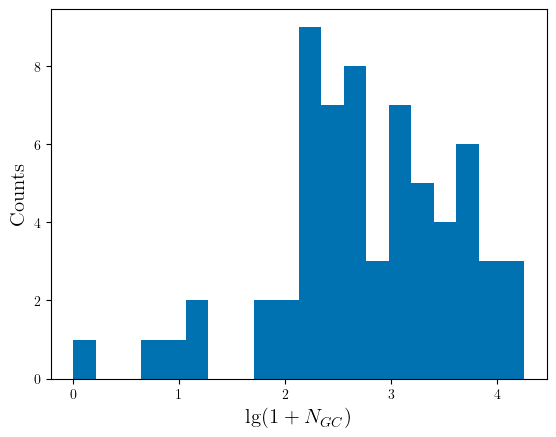

In [9]:
plt.hist(np.log10(1+y), bins=20)
plt.xlabel(r"$\lg(1+N_{GC})$",fontsize=15)
plt.ylabel("Counts", fontsize=15)
plt.show();

We perform a prior predictive check with our model to ensure that our data could reasonably be generated by our model.

Draw $\vec{\beta}_j\sim\mathcal{N}_9(0,\sigma\mathcal{I}_9)$

Draw $Y_j\sim\text{Poisson}(e^{X\beta_j})$

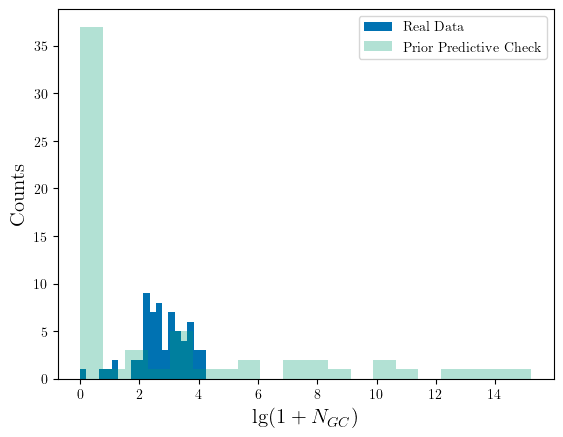

In [10]:
# sigma=10
Y_list = []
j = 0
while j<=62:
    beta = norm.rvs(loc=0, scale=10, size=9)
    try:
        Y = poisson.rvs(mu=np.exp(np.dot(x[j, :], beta)), size=1)
        Y_list.append(Y)
        j += 1
    except:
        continue
Y_list = np.asarray(Y_list)

plt.hist(np.log10(1+y), bins=20, label="Real Data")
plt.hist(np.log10(1+Y_list), bins=20, alpha=0.3, label="Prior Predictive Check")
plt.xlabel(r"$\lg(1+N_{GC})$",fontsize=15)
plt.ylabel("Counts", fontsize=15)
plt.legend()

From this, we feel confident in proceeding.

#### 3.3 Posterior 
<a id='posterior'></a>

We print the summary of the trace below.

In [11]:
summ = az.summary(trace)
summ["name"] = ['Intercept', 'Mdyn', 'MBH', 'sig_e', 'A_V', 'MV_T', 'Re', 'S', "E"]
display(summ)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,name
beta[0],6.575,0.007,6.562,6.588,0.0,0.0,19554.0,25729.0,1.0,Intercept
beta[1],-0.016,0.023,-0.059,0.027,0.0,0.0,12506.0,18831.0,1.0,Mdyn
beta[2],0.037,0.003,0.031,0.043,0.0,0.0,30817.0,28100.0,1.0,MBH
beta[3],0.071,0.011,0.051,0.091,0.0,0.0,13804.0,22002.0,1.0,sig_e
beta[4],-0.134,0.004,-0.141,-0.126,0.0,0.0,23823.0,27226.0,1.0,A_V
beta[5],-1.795,0.008,-1.810,-1.780,0.0,0.0,25474.0,26992.0,1.0,MV_T
beta[6],-0.258,0.007,-0.272,-0.245,0.0,0.0,13966.0,21837.0,1.0,Re
beta[7],0.004,0.007,-0.009,0.018,0.0,0.0,27544.0,26614.0,1.0,S
beta[8],0.615,0.006,0.603,0.625,0.0,0.0,30093.0,29142.0,1.0,E


In [19]:
print(f"Minimum ESS: {int(min(summ['ess_bulk']))}")

Minimum ESS: 12506


Our minimum ESS looks good, so we proceed with our analysis. We see that the only 94\% HDIs that contain zero are associated with Mdyn and the S indicator variable. We plot the traces below.

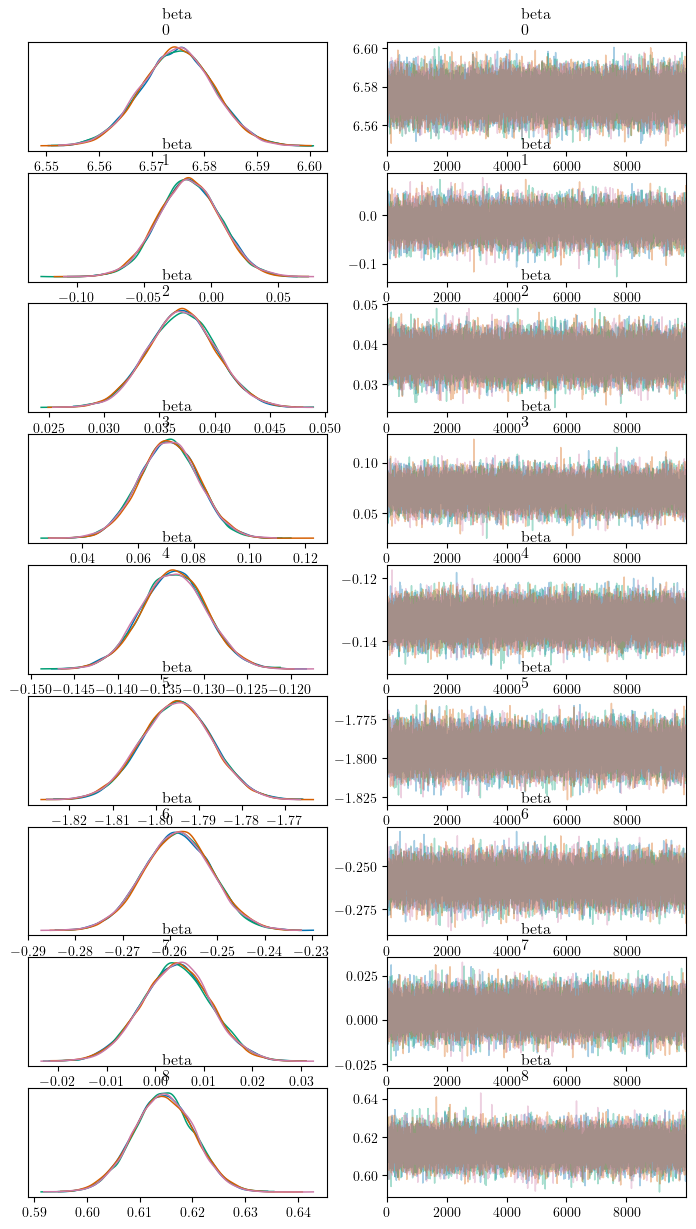

In [13]:
az.plot_trace(trace,var_names=['beta'],figsize=(8.5, 15), compact=False)
fig.set_tight_layout(True)
plt.show()

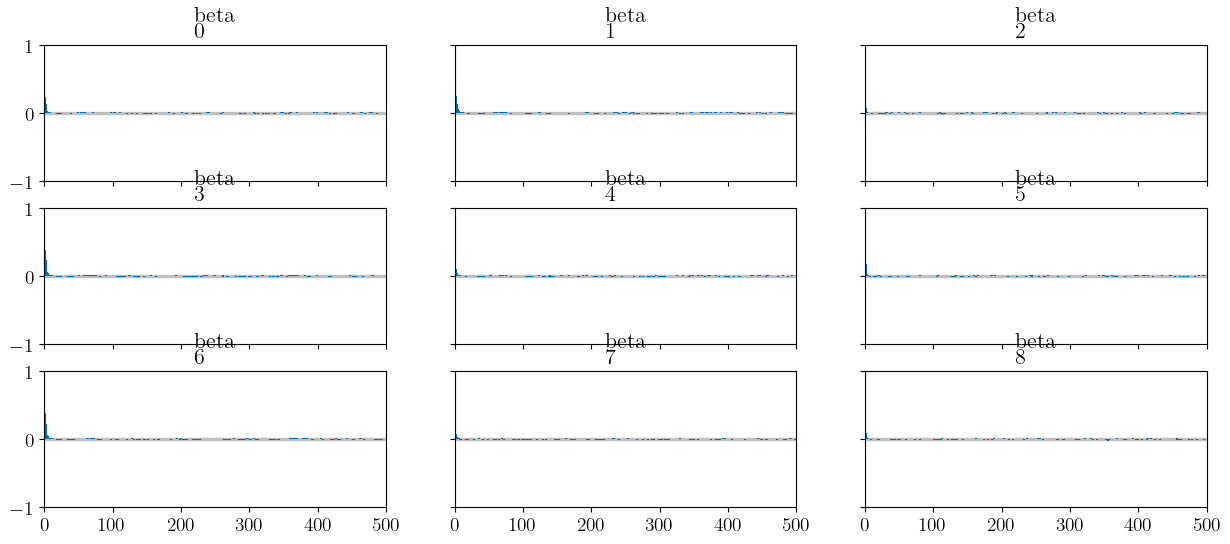

In [14]:
az.plot_autocorr(trace, var_names=['beta'], filter_vars="like",  max_lag=500,combined=True,figsize=(15, 6));
plt.show()

#### 3.4 Sensitivity Analysis
<a id='sensitivity'></a>

#### 3.5 Posterior Predictive Check
<a id='ppc'></a>

We predict the data for our parameters, and plot against the original data.

In [15]:
with poisson_log:
    predictive = mc.sample_posterior_predictive(trace, var_names='y')

Sampling: [x_star, y]


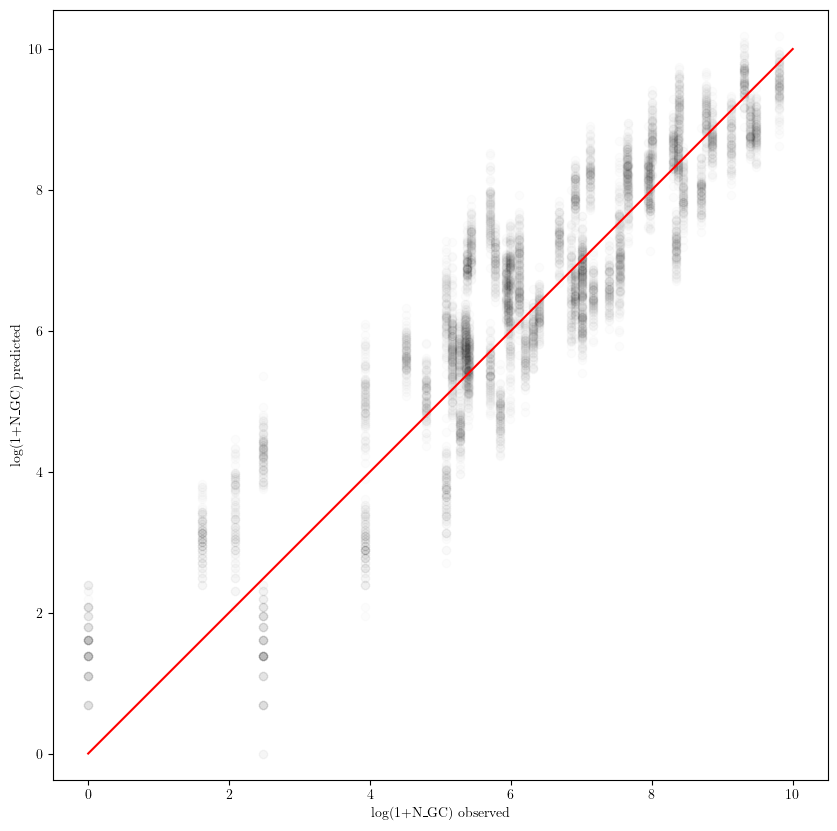

In [16]:
samples = np.array(predictive.posterior_predictive.y).reshape((40000, len(df)))[:100]

fig, ax = plt.subplots(figsize=(10,10))

for s in samples:
    ax.scatter(np.log(1+df["N_GC"]), np.log(1+s), c='black', alpha=0.01)
ax.plot([0,10], [0,10], c='r', alpha=1)
ax.axis('equal')
ax.set_xlabel("log(1+N_GC) observed")
ax.set_ylabel("log(1+N_GC) predicted")
plt.show()

### 4. Results
<a id='results'></a>

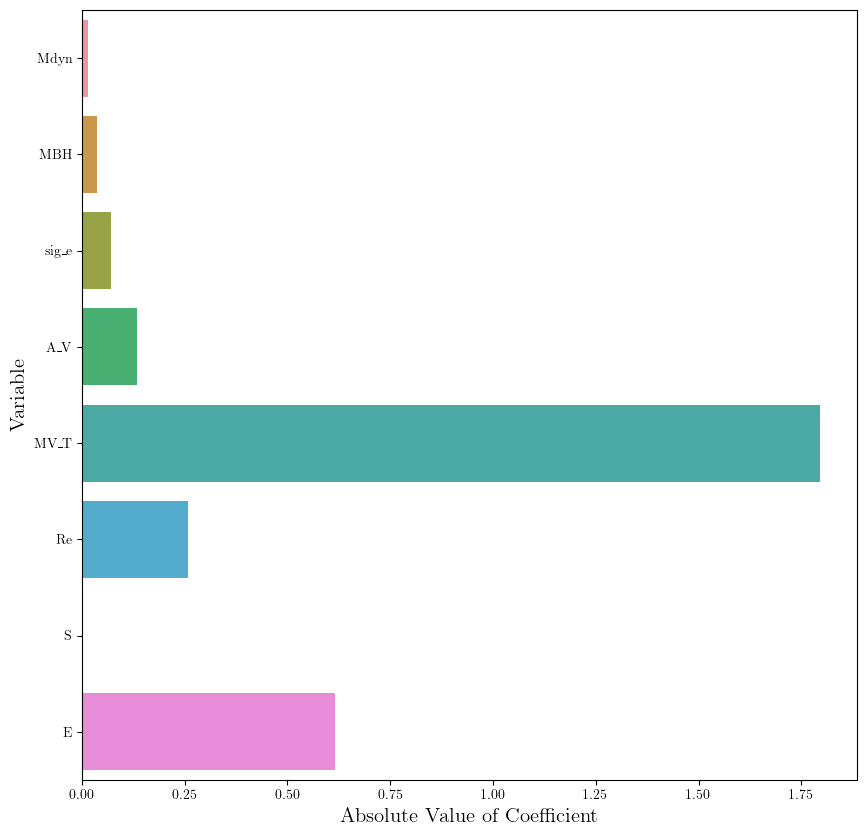

In [41]:
## plot the mean coefficients 

fig, ax = plt.subplots(figsize=(10,10)) 
## skips the intercept
sns.barplot(x=np.abs(summ["mean"][1:]), y=summ["name"][1:], ## if someone wants to add the sd or hdi, I wasn't sure what to do with seaborn
            data=summ, ax=ax)
ax.set_xlabel("Absolute Value of Coefficient", fontsize=15)
ax.set_ylabel("Variable", fontsize=15)
plt.show();

From the posterior predictive check, we see that the prediction of the number of globular clusters is closely correlated with the observed values. This suggests the 